In [5]:
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
def read_data():
    df = pd.concat([pd.read_csv('../data/cleaned_0.csv'),
                    pd.read_csv('../data/cleaned_1.csv')], ignore_index=True)
    return df

In [7]:
""" TOKENIZATION """

def tokenize(text):
    return text.split(' ')

In [8]:
""" PADDING """

def pad(tokens, max_len):
    if (len(tokens) > max_len):
        return tokens[:max_len]
    return tokens + [''] * (max_len - len(tokens))

In [9]:
""" GENERATE TOKENS """

def token_gen(text):
    # create a generator to convert from tokens to ids
    res = []
    for sentence in text:
        tokens = tokenize(sentence)
        res.append(tokens)

    return res

In [10]:
""" BUILD VOCAB """

def build_vocab(token_list, max_tokens=2048):
    vocab = dict()
    for tokens in token_list:
        for w in tokens:
            if w in vocab:
                vocab[w] += 1
            else:
                vocab[w] = 1

    # print("Actual vocab size: ", len(vocab))
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)[
        :max_tokens]

    # print("sorted vocab: ", sorted_vocab[:20])
    vocab = dict(sorted_vocab)
    word_to_id = {w: i for i, w in enumerate(vocab.keys())}
    return vocab, word_to_id

In [11]:
""" TF-IDF"""

from sklearn.decomposition import PCA


def build_tfidf(token_list, vocab, word_to_id):
    n_docs = len(token_list)
    n_words = len(word_to_id)
    tf = np.zeros((n_words, n_docs), dtype=np.float32)
    count = np.zeros(n_words)
    # idf = np.zeros(n_words, dtype=np.float32)
    for i, tokens in enumerate(token_list):
        new_count = np.zeros(n_words)
        for w in tokens:
            if (w in word_to_id):
                id = word_to_id[w]
                tf[id, i] += (1 / len(tokens))
                if new_count[id] == 0:
                    new_count[id] = 1
        
        count += new_count

    idf = np.log10(n_docs / count)
    tf_idf = tf * idf[:, np.newaxis]
    n_components = 50
    pca = PCA(n_components=n_components)

    tf_idf = pca.fit_transform(tf_idf)
    # lin = np.random.rand(n_docs, 100) / 10
    # print(lin)
    # tf_idf = tf_idf @ lin
    return tf_idf

In [12]:
def embed(token_list, tf_idf):
    shape = token_list.shape
    res = []

    for i in range(shape[0]):
        r = np.zeros(50, dtype=np.float32)
        for j in range(shape[1]):
            r += tf_idf[token_list[i, j]]
        # r = r / shape[1]
        res.append(r)

    return torch.tensor(np.array(res), dtype=torch.float32)

In [49]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embed, tf_idf):
        super(RNN, self).__init__()
        self.embed = embed
        self.tf_idf = tf_idf  
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens):
        embedded = embed(tokens, tf_idf)
#         embedded = torch.tensor(tokens, dtype=torch.float32)
#         print("embedded shape: ", embedded.shape)
#         print("Embedded[0]: ", [i for i in embedded[0] if i != 0])
        out, _ = self.rnn(embedded)
        out = self.fc(out)
        out = out.reshape(-1)
        out = self.sigmoid(out)
        return out

In [14]:
df = read_data()
data = list(df['text'])

# list of lists of tokens

In [15]:
token_list = token_gen(data)

for i in range(len(token_list)):
    token_list[i] = pad(token_list[i], 50)

vocab, word_to_id = build_vocab(token_list, 5000)

In [40]:
tf_idf = build_tfidf(token_list, vocab, word_to_id)

In [41]:
print(tf_idf[10])

[ 0.13905981  0.02052438 -0.04059468 -0.08749468  0.10230517 -0.15110742
 -0.16996091 -0.18767006 -0.11102662 -0.20845773 -0.10990461 -0.07914307
 -0.03479407 -0.08162923  0.21401234  0.07425726 -0.12741337  0.04371809
  0.03676002 -0.04663432 -0.12880674  0.08625409  0.04971879  0.07089673
 -0.03249509  0.01051387  0.0031495  -0.03120289  0.04465434  0.04506883
 -0.03608802  0.02562635  0.02029967  0.0128169   0.01421497 -0.0358487
 -0.01306468  0.00407379  0.01967975  0.00964356  0.01437023 -0.03711509
  0.02000143  0.02619302 -0.01424058  0.00546649  0.00167438 -0.00697174
 -0.0030188   0.02105458]


In [18]:
X = []
y = torch.tensor(df['label'].values, dtype=torch.float32, requires_grad=False)

for i in range(len(token_list)):
    X.append([word_to_id[w] if w in word_to_id else 0 for w in token_list[i]])

X = np.array(X)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size=0.7, shuffle=True)

In [19]:
torch.set_printoptions(threshold=torch.inf)
np.set_printoptions(threshold=np.inf)

In [139]:
model = RNN(input_size=50, hidden_size=128,
                output_size=1, embed=embed, tf_idf=tf_idf)

def train():
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.BCELoss()

    epochs = 400

    accuracies = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_X)
        loss = loss_fn(output, train_y)
        loss.backward()
        optimizer.step()
#         optimizer.zero_grad()
#         output = model(train_X)
#         loss = loss_fn(output, train_y)
        accuracies.append(accuracy_score(np.round(output.detach().reshape(-1)), train_y))
#         loss.backward()
#         optimizer.step()

    predict = model(valid_X).detach().reshape(-1)
    # print(predict)
    # print(valid_y)
    print(accuracy_score(np.round(predict), valid_y))
    return predict, valid_y, accuracies

pred, val, accuracies = train()

0.5835010060362174


In [44]:
print(pred[:100])   

tensor([0.0998, 0.2132, 0.2833, 0.3550, 0.3884, 0.4237, 0.4441, 0.4612, 0.4742,
        0.4231, 0.4331, 0.4052, 0.4268, 0.4447, 0.4354, 0.4512, 0.4528, 0.4879,
        0.4840, 0.4912, 0.4938, 0.4889, 0.4884, 0.4898, 0.4683, 0.4713, 0.4590,
        0.4492, 0.4441, 0.4493, 0.4929, 0.4990, 0.5040, 0.4901, 0.4257, 0.4265,
        0.4022, 0.4251, 0.4284, 0.4492, 0.4637, 0.4585, 0.4631, 0.4164, 0.4327,
        0.4299, 0.4481, 0.4646, 0.4887, 0.4804, 0.4864, 0.5190, 0.5170, 0.4982,
        0.4946, 0.4799, 0.4815, 0.4902, 0.4755, 0.4667, 0.4776, 0.4772, 0.4527,
        0.4760, 0.4706, 0.4685, 0.4518, 0.4712, 0.4954, 0.4956, 0.4898, 0.4911,
        0.4694, 0.4714, 0.4497, 0.4748, 0.4768, 0.4778, 0.4922, 0.4813, 0.4856,
        0.4674, 0.4548, 0.4622, 0.4608, 0.4709, 0.4754, 0.4915, 0.4905, 0.4698,
        0.4793, 0.4816, 0.4146, 0.4324, 0.4186, 0.3994, 0.4195, 0.4244, 0.4389,
        0.4549])


In [177]:
print(val[:100])

tensor([1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 1.])


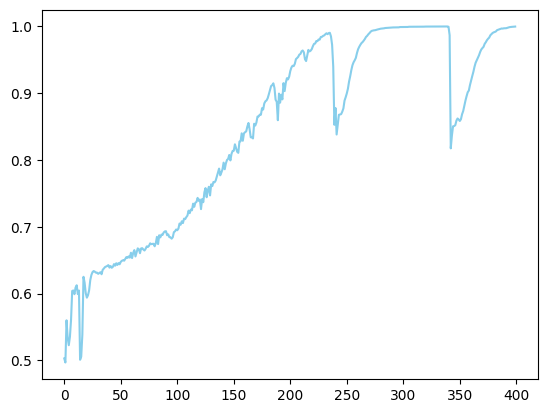

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(accuracies)), accuracies, color="skyblue")

In [79]:
def predict(text):
    tokens = text.split(' ')
    tokens = pad(tokens, 50)
    tokens = np.array([[word_to_id[w] if w in word_to_id else 0 for w in tokens]])
    return "Positive" if model(tokens)[0] > 0.5 else "Negative"

In [144]:
print(1, predict("it's good to see you"))
print(2, predict("i hate this job"))
print(3, predict("bad luck"))
print(4, predict("get out"))
print(5, predict("you are funny"))
print(6, predict("nice try, man"))
print(7, predict("how bad you are"))
print(8, predict("this is so bad"))
print(9, predict("good luck"))
print(10, predict("i love my family"))
print(11, predict("i hate everyone"))
print(12, predict("what the hell am i watching"))
print(13, predict("worst thing ever"))
print(14, predict("give me the bear or im gonna kill you"))
print(15, predict("lol what a nice day to work"))
print(16, predict("good morning"))
print(17, predict("love the smell of a freshday"))
print(18, predict("wanna try some candies"))
print(19, predict("i wanna suicide"))
print(20, predict("i cant take it anymore"))

1 Positive
2 Negative
3 Negative
4 Negative
5 Positive
6 Positive
7 Negative
8 Negative
9 Positive
10 Positive
11 Negative
12 Negative
13 Negative
14 Negative
15 Positive
16 Positive
17 Positive
18 Positive
19 Positive
20 Negative


In [142]:
torch.save(model, 'text_classification.pth')